# Introduction
Use this notebook to create the volcano plots of the DESeq2 results.

# Setup

In [16]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
from scipy import sparse
import warnings
import itertools as it
import json
import seaborn as sns
import pickle as pkl
from functools import reduce
import gc
import timeit
import os

from nero import Nero as nr

In [17]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=30

In [18]:
mountpoint = '/data/clue/'
prefix_adts = mountpoint + 'prod/adts/'
prefix_mrna = mountpoint + 'prod/mrna/'
prefix_comb = mountpoint + 'prod/comb/'

## Functions

In [21]:
def get_xtix_labels(xtix):
    if len(xtix) > 5: # only if more than [-2, -1, 0, 1, 2]
        labels = list()
        for xtick in xtix:
            if xtick % 2 == 0:
                labels.append(xtick)
            else:
                labels.append('')
    else:
        labels = xtix
    return labels

In [22]:
def subsetdict(df, sdict):
    return df.loc[pd.concat([df[i].isin([j]) if type(j) == str else df[i].isin(j) for i, j in sdict.items()], axis=1).all(1), :]

In [23]:
def plot_volcano(de_df, de_keys, padj_thresh=0.05, l2fc_thresh=1.5, ax=None, show_table=False, sort_by='l2fc'):
    assert sort_by in ['l2fc', '-log10p']
    if isinstance(ax, type(None)):
        no_ax = True
    else:
        no_ax = False
    
    if no_ax:
        if show_table:
            fig, (ax, tab1, tab2) = plt.subplots(1, 3, figsize=(12, 4))
        else:
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    else:
        assert not show_table, "Cannot provide both `ax` and `show_table == True`"
    
    de_df = subsetdict(de_df, de_keys)
    x = de_df['l2fc'].values
    y = de_df['-log10p'].values
    
    mybool = (de_df['padj'] < padj_thresh) & (de_df['l2fc'].abs() > l2fc_thresh)
        
    ax.scatter(x, y, c='lightgray', s=1)
    ax.scatter(x[mybool], y[mybool], c='k', s=3)
    
    xmax = np.abs(x).max()
    xmax *= 1.1
    ax.set_xlim((-xmax, xmax))
    max_xtix = int(np.floor(xmax))
    xtix = np.arange(-max_xtix, max_xtix+1)
    ax.set_xticks(ticks=xtix)
    ax.set_xticklabels(get_xtix_labels(xtix))
    
    ax.set_xlabel('log2(Fold Change)')
    ax.set_ylabel('-log10(padj)')
    ax.set_title(', '.join([i if type(i) == str else '&'.join(i) for i in de_keys.values()]), fontsize=10)
    
    if no_ax and show_table:
        cols = ['l2fc', '-log10p']
        col_labels=['gene', 'l2fc', '-log10p']
        bbox = [0, 0, 1, 1]
        top_num = 10
        
        de_df_filt = de_df[cols][de_df['l2fc'] < 0]
        if sort_by in ['l2fc']:
            asc=True
        else:
            asc=False
        de_df_head = de_df_filt.sort_values(by=sort_by, ascending=asc).head(top_num)
        de_df_fmt = de_df_head.apply(lambda s: s.apply(lambda x: '{:03.2f}'.format(x)))
        de_df_idx = de_df_fmt.rename_axis('gene').reset_index()

        with plt.rc_context({'font.family':  'Liberation Mono'}):
            tab1.axis('off')
            tab1.set_title('l2fc < 0 top hits', fontsize=10)
            tab = tab1.table(cellText=de_df_idx.values.tolist(),
                       colColours=['lightgray', 'lightgray', 'lightgray'],
                       bbox=bbox, cellLoc='center', colLabels=col_labels
                      )
            tab.auto_set_font_size(False)
            tab.set_fontsize(8)
            
        de_df_filt = de_df[cols][de_df['l2fc'] > 0]
        asc=False
        de_df_head = de_df_filt.sort_values(by=sort_by, ascending=asc).head(top_num)
        de_df_fmt = de_df_head.apply(lambda s: s.apply(lambda x: '{:03.2f}'.format(x)))
        de_df_idx = de_df_fmt.rename_axis('gene').reset_index()

        with plt.rc_context({'font.family':  'Liberation Mono'}):
            tab2.axis('off')
            tab2.set_title('l2fc > 0 top hits', fontsize=10)
            tab = tab2.table(cellText=de_df_idx.values.tolist(),
                       colColours=['lightgray', 'lightgray', 'lightgray'],
                       bbox=bbox, cellLoc='center', colLabels=col_labels
                      )
            tab.auto_set_font_size(False)
            tab.set_fontsize(8)
    
    return ax

# Load in Data

In [19]:
de = dict()

In [20]:
de['mrna'] = pd.read_pickle(prefix_mrna + 'pkls/de.pkl')
de['adts'] = pd.read_pickle(prefix_adts + 'pkls/de.pkl')

# Plotting Single Sample

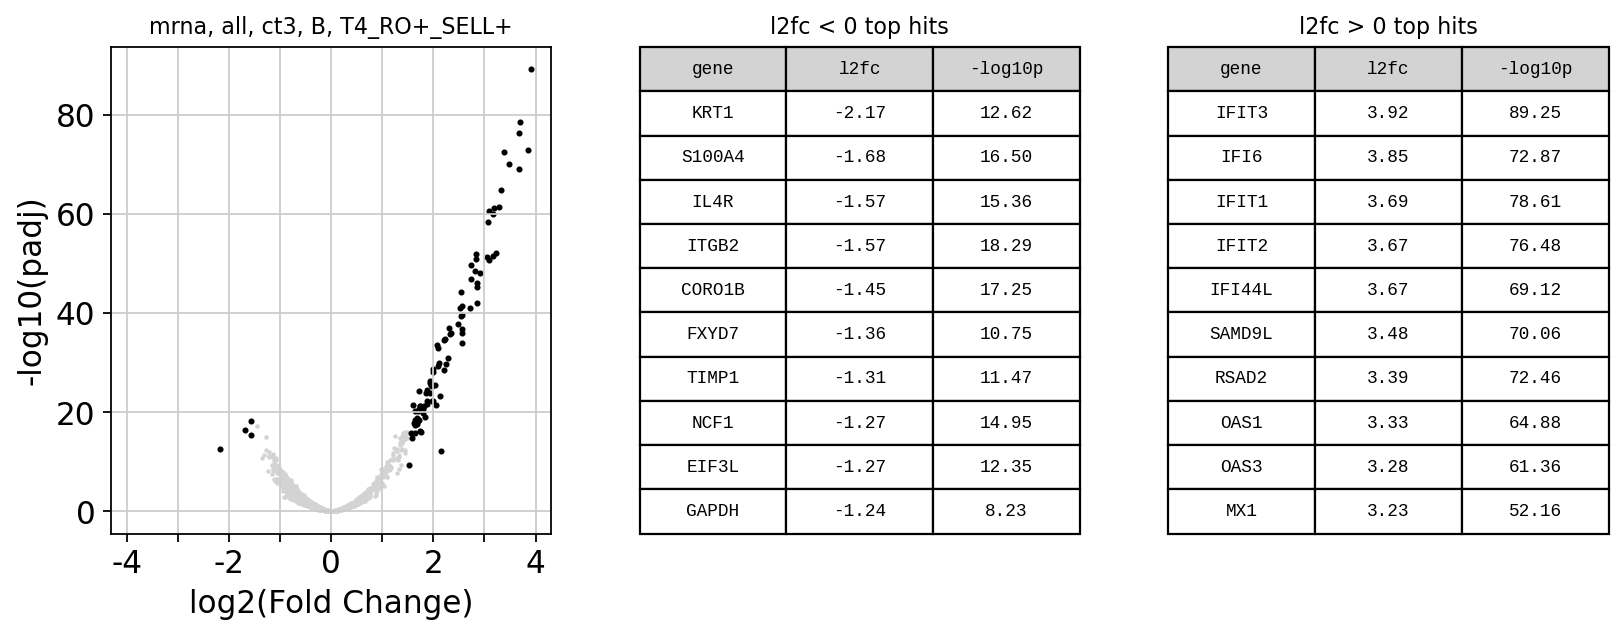

In [25]:
de_keys={
    'mod': 'mrna',
    'anlys': 'all',
    'cttype': 'ct3',
    'cond': 'B',
    'ct': 'T4_RO+_SELL+',
}

plot_volcano(de['mrna'], de_keys, show_table=True);

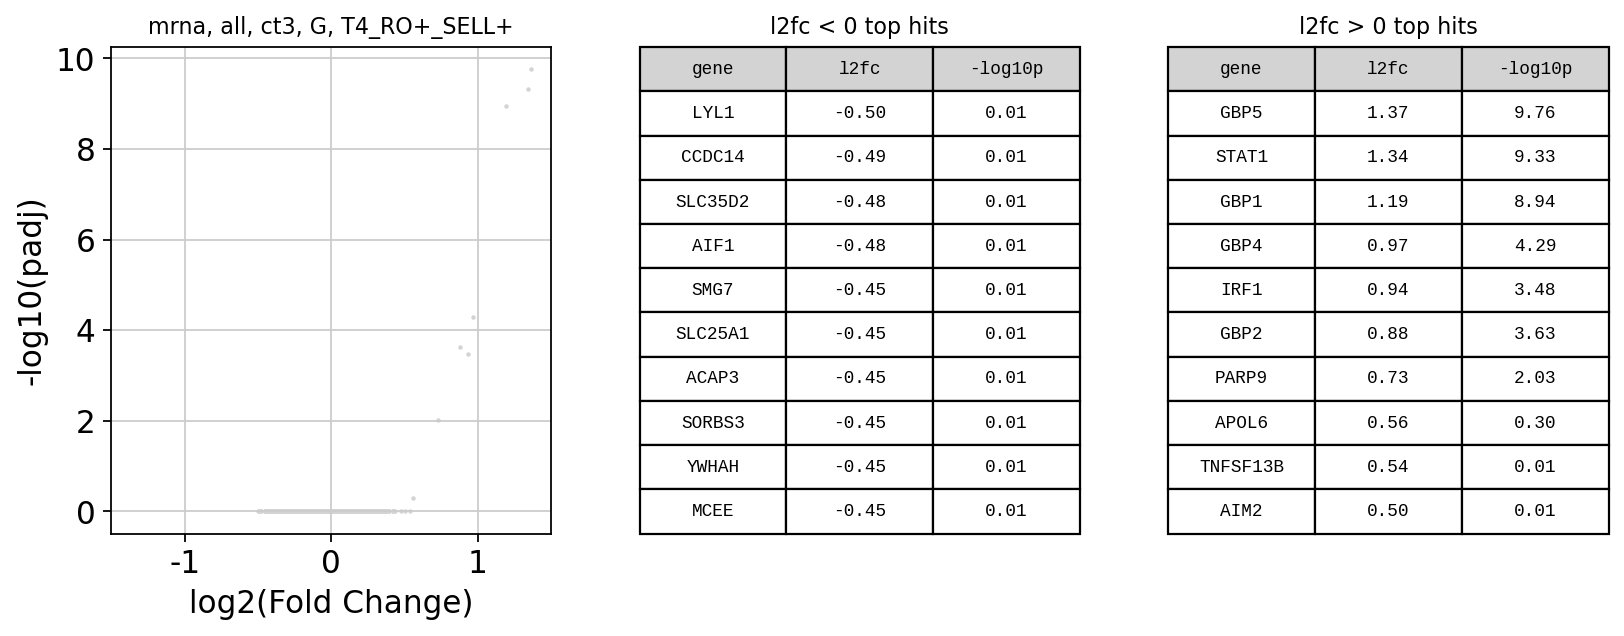

In [26]:
de_keys={
    'mod': 'mrna',
    'anlys': 'all',
    'cttype': 'ct3',
    'cond': 'G',
    'ct': 'T4_RO+_SELL+',
}

plot_volcano(de['mrna'], de_keys, show_table=True);

# Plotting All `ct`s in One Condition

In [ ]:
de_keys={
    'mod': 'mrna',
    'anlys': 'all',
    'cttype': 'ct2',
    'cond': 'G',
}
ct2s = subsetdict(de['mrna'], de_keys)['ct'].unique()

de_keys={
    'mod': 'mrna',
    'anlys': 'all',
    'cttype': 'ct3',
    'cond': 'G',
}
ct3s = subsetdict(de['mrna'], de_keys)['ct'].unique()

In [33]:
ct3s

array(['MAIT', 'NK_CD16+', 'NK_CD56++', 'T4_CM', 'T4_RA+_SELL+',
       'T4_RA+_SELLint', 'T4_RO+_Act', 'T4_RO+_SELL+', 'T4_Treg_Act',
       'T4_Treg_Resting', 'T8_CM', 'T8_EM', 'T8_HOBIT+HELIOS+',
       'T8_RA+_SELL+', 'T8_TEMRA', 'T_CD10+', 'T_gd', 'cDC1', 'cDC2'],
      dtype=object)

In [34]:
len(ct3s)

19

0it [00:00, ?it/s]

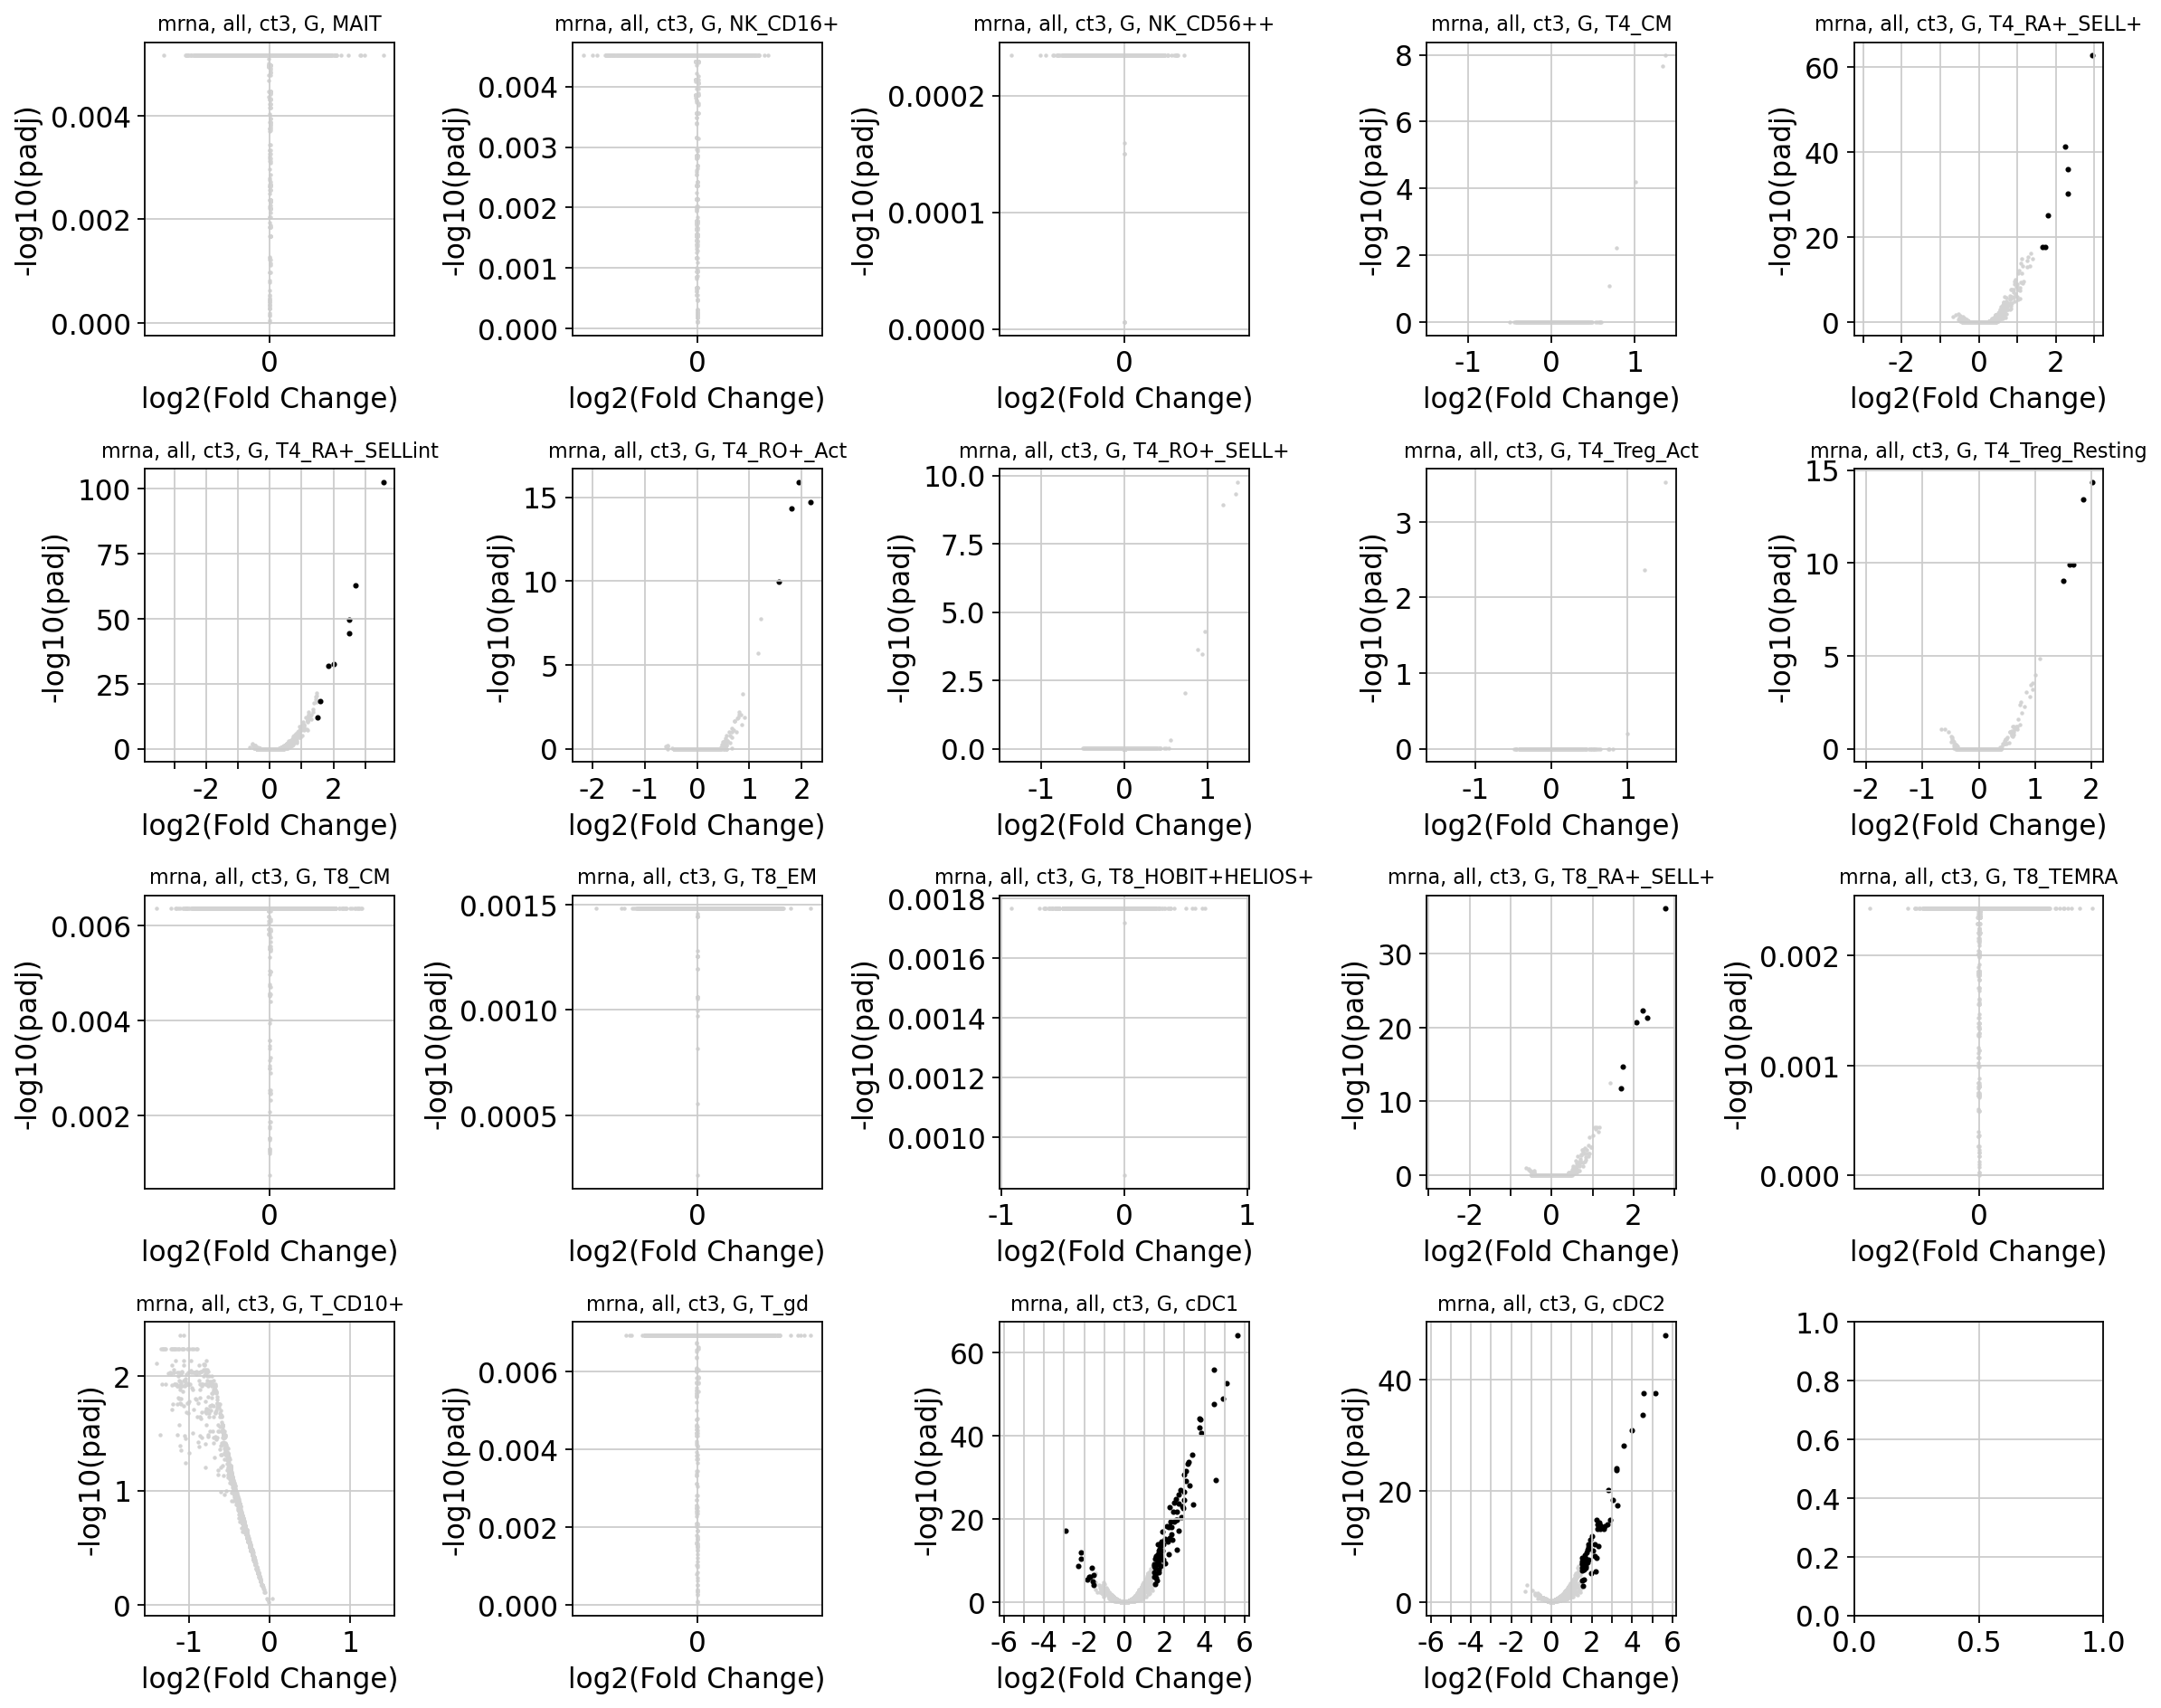

In [32]:
fig, axes = plt.subplots(4, 5, figsize=(15,12))
for ct, ax in tqdm(zip(ct3s, np.ravel(axes))):
    de_keys={
        'mod': 'mrna',
        'anlys': 'all',
        'cttype': 'ct3',
        'cond': 'G',
        'ct': ct
    }
    plot_volcano(de['mrna'], de_keys, show_table=False, ax=ax);
    
plt.tight_layout()